<a href="https://colab.research.google.com/github/SimonHeilles/OC/blob/main/OC_P7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-r_9370q6
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-r_9370q6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=95491 sha256=7480bab012e11358494f73ba4f5527d8ac45ddc36f63ca626a55bd2b917959bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-azexucou/wheels/5c/8e/11/307eca5379b418a9989ef4d24ead655755f2500a577ec95208
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  12.4M      0  0:00:01  0:00:01 --:--:-- 12.4M
  % Total    % Received % Xferd  Average S

In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [3]:
FASTA_PATH = "./P62593.fasta" # Path to P62593.fasta
EMB_PATH = "./P62593_reprs/" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34 # modif de 33 en 34 : on ne commençait pas au bon endroit et on avait une key error

In [4]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    print(scaled_effect)
    print(header)
    fn = f'{EMB_PATH}/{header}.pt' # modif du header pour charger les fichiers
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

Streaming output truncated to the last 5000 lines.
0.864324677
2898|beta-lactamase_I259F|0.864324677
0.864324677
2899|beta-lactamase_G154K|0.864324677
0.86429389
2900|beta-lactamase_E87E|0.86429389
0.8642904709999999
2901|beta-lactamase_R189I|0.8642904709999999
0.8641096659999999
2902|beta-lactamase_T267F|0.8641096659999999
0.86404614
2903|beta-lactamase_L160N|0.86404614
0.86404614
2904|beta-lactamase_D48H|0.86404614
0.86404614
2905|beta-lactamase_V214I|0.86404614
0.86404614
2906|beta-lactamase_E62F|0.86404614
0.86404614
2907|beta-lactamase_R41D|0.86404614
0.863960135
2908|beta-lactamase_L89P|0.863960135
0.863956226
2909|beta-lactamase_V214L|0.863956226
0.8639484070000001
2910|beta-lactamase_L38A|0.8639484070000001
0.86392886
2911|beta-lactamase_L111P|0.86392886
0.863613503
2912|beta-lactamase_F13F|0.863613503
0.8633043490000001
2913|beta-lactamase_D99F|0.8633043490000001
0.86324571
2914|beta-lactamase_L74I|0.86324571
0.8632105259999999
2915|beta-lactamase_F228V|0.8632105259999999
0.86

In [5]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((4317, 1280), (1080, 1280), 4317, 1080)

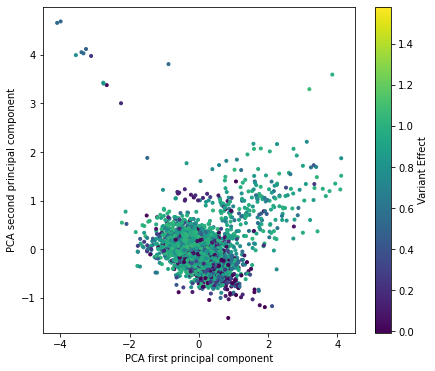

In [6]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [7]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [8]:
result_list[0].sort_values('rank_test_score')[:5] # KNN

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.510218,0.013215,0.519211,0.013053,"KNeighborsRegressor(algorithm='kd_tree', p=1, ...",kd_tree,30,5,1,distance,{'model': KNeighborsRegressor(algorithm='kd_tr...,0.666047,0.690838,0.661078,0.674910,0.621450,0.662865,0.023048,1
1,0.975070,0.178515,0.869155,0.089363,"KNeighborsRegressor(algorithm='kd_tree', p=1, ...",ball_tree,15,5,1,distance,{'model': KNeighborsRegressor(algorithm='kd_tr...,0.662222,0.690080,0.661102,0.676457,0.623634,0.662699,0.022216,2
33,0.580668,0.128374,0.256222,0.018239,"KNeighborsRegressor(algorithm='kd_tree', p=1, ...",brute,15,5,1,distance,{'model': KNeighborsRegressor(algorithm='kd_tr...,0.670311,0.686964,0.659066,0.673224,0.623534,0.662620,0.021469,3
9,0.484586,0.011353,0.442516,0.010984,"KNeighborsRegressor(algorithm='kd_tree', p=1, ...",ball_tree,30,5,1,distance,{'model': KNeighborsRegressor(algorithm='kd_tr...,0.669355,0.687777,0.656899,0.666610,0.625345,0.661197,0.020524,4
41,0.509959,0.017124,0.239501,0.007253,"KNeighborsRegressor(algorithm='kd_tree', p=1, ...",brute,30,5,1,distance,{'model': KNeighborsRegressor(algorithm='kd_tr...,0.668315,0.688722,0.651077,0.672171,0.625596,0.661176,0.021441,5


In [9]:
result_list[1].sort_values('rank_test_score')[:5] # SVR

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.644320,0.028805,0.275348,0.009494,SVR(),1.0,3,scale,rbf,"{'model': SVR(), 'model__C': 1.0, 'model__degr...",0.700618,0.690743,0.665142,0.698395,0.670090,0.684997,0.014649,1
10,3.187454,0.681020,0.298039,0.013331,SVR(),10.0,3,scale,rbf,"{'model': SVR(), 'model__C': 10.0, 'model__deg...",0.700002,0.694849,0.651243,0.686837,0.685165,0.683619,0.017061,2
2,1.464694,0.015004,0.305315,0.011157,SVR(),0.1,3,scale,rbf,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",0.607832,0.589897,0.550004,0.601315,0.562931,0.582396,0.022313,3
8,6.909381,0.188398,0.136112,0.002974,SVR(),10.0,3,scale,linear,"{'model': SVR(), 'model__C': 10.0, 'model__deg...",0.526010,0.485379,0.441526,0.516898,0.472487,0.488460,0.030614,4
4,1.947767,0.044651,0.143310,0.008010,SVR(),1.0,3,scale,linear,"{'model': SVR(), 'model__C': 1.0, 'model__degr...",0.526780,0.485609,0.442410,0.515983,0.471384,0.488433,0.030484,5


In [10]:
result_list[2].sort_values('rank_test_score')[:5] # RFR

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__criterion,param_model__max_features,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.162617,0.021150,0.017645,0.000776,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,1,5,20,{'model': RandomForestRegressor(max_features='...,0.512593,0.553585,0.515295,0.532027,0.498110,0.522322,0.018983,1
3,1.053040,0.016309,0.019461,0.005049,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,4,10,20,{'model': RandomForestRegressor(max_features='...,0.519015,0.534646,0.517976,0.535921,0.485589,0.518629,0.018154,2
2,1.065265,0.012387,0.016301,0.000613,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,4,5,20,{'model': RandomForestRegressor(max_features='...,0.518996,0.534439,0.515799,0.544104,0.476329,0.517933,0.023212,3
4,0.999761,0.016167,0.018037,0.001131,"RandomForestRegressor(max_features='sqrt', min...",squared_error,log2,1,5,20,{'model': RandomForestRegressor(max_features='...,0.497851,0.554545,0.503120,0.518498,0.506335,0.516070,0.020399,4
1,1.113869,0.016339,0.017735,0.001351,"RandomForestRegressor(max_features='sqrt', min...",squared_error,sqrt,1,10,20,{'model': RandomForestRegressor(max_features='...,0.500163,0.546241,0.506560,0.521491,0.490227,0.512936,0.019504,5


In [11]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')

KNeighborsRegressor(algorithm='kd_tree', p=1, weights='distance')

SpearmanrResult(correlation=0.7946962902983652, pvalue=5.862706898531395e-236)

 -------------------------------------------------------------------------------- 

SVR()

SpearmanrResult(correlation=0.8000959864268189, pvalue=1.6955894463907153e-241)

 -------------------------------------------------------------------------------- 

RandomForestRegressor(max_features='sqrt', min_samples_split=5, n_estimators=20)

SpearmanrResult(correlation=0.707165154148806, pvalue=1.7449675161634108e-164)

 -------------------------------------------------------------------------------- 



# XGBoost

In [12]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

parameters = {
    'n_estimators': [100, 500], #number of trees, plus il y en a plus il y a d'estimateurs pour régler le pb, plus on a d'informations ajoutées au modèle, essayer de lui en donner plus
    'max_depth': [5, 10], # à ajuster aussi, la complexité de chaque arbre
    'learning_rate': [0.1, 0.01] # contrôle l'apport de chaque arbre, essayer de le réduire
}

xgb_search1 = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=3,
                   scoring='r2',
                   verbose=2, refit=True)

xgb_results1 = xgb_search1.fit(Xs_train, ys_train)
xgb_results1_bs = xgb_results1.best_score_

# summarize
print('R^2: %.3f' % xgb_results1.best_score_)
print('Config: %s' % xgb_results1.best_params_)

xgboost_preds = grid.predict(Xs_test)
print(f'{scipy.stats.spearmanr(ys_test, xgboost_preds)}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[11:14:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2: 0.675
Config: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
SpearmanrResult(correlation=0.707165154148806, pvalue=1.7449675161634108e-164)


# Théorie de l'ensemble learning : stacking de modèles

On a des modèles différents dans le stacking, par opposition au RFR où on a les mêmes modèles. Pour chaque ADN nous allons calculer la moyenne des quatre scores prédits, afin de générer un nouveau score.

In [13]:
# faire la moyenne des 4 scores prédits par chaque modèle pour chaque ADN pour avoir un nouveau score
# comparer avec y test pour le calcul du R de Spearman

In [14]:
df_score = pd.DataFrame(scipy.stats.spearmanr(ys_test, xgboost_preds), columns=['score4'])
df_preds = pd.DataFrame(xgboost_preds, columns=['preds4'])

In [15]:
i = 1

for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    df_preds['preds' + str(i)] = grid.predict(Xs_test)
    df_score['score' + str(i)] = scipy.stats.spearmanr(ys_test, df_preds['preds' + str(i)])

    i = i + 1

KNeighborsRegressor(algorithm='kd_tree', p=1, weights='distance')
SVR()
RandomForestRegressor(max_features='sqrt', min_samples_split=5, n_estimators=20)


In [16]:
df_preds['avg_preds'] = (df_preds['preds1'] + df_preds['preds2'] + df_preds['preds3'] + df_preds['preds4'])/4

In [17]:
df_score['avg_score'] = scipy.stats.spearmanr(ys_test, df_preds['avg_preds'])

In [18]:
df_score

,score4,score1,score2,score3,avg_score
0,7.071652e-01,7.946963e-01,8.000960e-01,7.071652e-01,8.006554e-01
1,1.744968e-164,5.862707e-236,1.695589e-241,1.744968e-164,4.423485e-242
